### Exercise 1
#### 1.1 Implement a two-dimensional k-nearest neighbors classifier (in particular, do not use sklearn for k-nearest neighbors here): given a list of (x, y; class) data, store this data in a quad-tree (14 points). 
#### 1.2 Given a new (x, y) point and a value of k (the number of nearest neighbors to examine), it should be able to identify the most common class within those k nearest neighbors (14 points). You may assume distance will be measured using the traditional euclidean distance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
class QuadTree:
    def __init__(self, data, bounding_box=None, max_leaf_data=3):
        if bounding_box is None:
            xs, ys, conditions = zip(*data)
            self.xlo = min(xs) #find the samllest bounding box
            self.ylo = min(ys)
            self.xhi = max(xs)
            self.yhi = max(ys)
        else:
            self.xlo = bounding_box['xlo'] #otherwise defined by bounding box
            self.xhi = bounding_box['xhi']
            self.ylo = bounding_box['ylo']
            self.yhi = bounding_box['yhi']
        if len(data) <= max_leaf_data: # when the data has more than defined max number of branchess
            self._data = data #create a children node empty list
            self.children = []
        else: # start splitting the dataset and make quadtree based on the median num
            self._data = None
            self.children = []
            xsplit = (self.xlo + self.xhi) / 2
            ysplit = (self.ylo + self.yhi) / 2
            bbox = [ #use bbox to record the bounding boxs, defined by its 4 perimeters
                    #xsplit = median value, xlo = x lower bound
                {'xlo': self.xlo, 'xhi': xsplit, 'ylo': self.ylo, 'yhi': ysplit},
                {'xlo': self.xlo, 'xhi': xsplit, 'ylo': ysplit, 'yhi': self.yhi},
                {'xlo': xsplit, 'xhi': self.xhi, 'ylo': self.ylo, 'yhi': ysplit},
                {'xlo': xsplit, 'xhi': self.xhi, 'ylo': ysplit, 'yhi': self.yhi}
            ]
            self.children = [
                QuadTree(get_data_in_range(data, my_bbox), my_bbox, max_leaf_data)
                for my_bbox in bbox
            ]
    
    def get_descendant_count(self):
        if not self.children:
            return len(self._data)
        else:
            return sum(child.get_descendant_count() for child in self.children)

    def __repr__(self):
        return f'<QuadTree xlo={self.xlo} ylo={self.ylo} xhi={self.xhi} yhi={self.yhi} #desc={self.get_descendant_count()}>'

    def contains(self, x, y):
        return (self.xlo <= x < self.xhi and self.ylo <= y < self.yhi)

#if given the a new point defined by x and y, defined distance, return T/F which represents whether the value is within the distance
    def within_distance(self, x, y, d): 
        if self.contains(x,y):
            return True 
        else: 
            dx = min(abs(x-self.xhi),abs(x-self.xlo))
            dy = min(abs(y-self.yhi),abs(y-self.ylo))
            if self.xlo <= x <= self.xhi:
                distance = dy #calculate distance of the point from the box
            elif self.ylo <= y <= self.yhi:
                distance = dx
            else:
                distance = (dx**2 + dy**2)**0.5
            return distance <= d


def get_data_in_range(data, bbox):
    result = []
    for x, y, condition in data:
        if bbox['xlo'] <= x < bbox['xhi'] and bbox['ylo'] <= y < bbox['yhi']:
            result.append([x, y, condition])
    return result

def find_leaves_under_node(node,x,y,d):
    result = []
    
    def dfs(node):
        
        if not node.children:
            
            if node.within_distance(x,y,d):
                
                result.append(node)
        else:
            for child in node.children:
                dfs(child)
    dfs(node)
    
    return result

In [19]:
class knn:
  def __init__(self, data):
    self.root = QuadTree(data = data)

  def get_initial_r(self,k):
    r = float('inf')
    q = deque([self.root])
    while q:
      node = q.popleft()
      r = min(r, ((node.xhi - node.xlo)**2 + (node.yhi - node.ylo)**2)**0.5)
      for child in node.children:
        if child.get_descendant_count() >= k:
          q.append(child)
    return r
  
  def classify(self,x,y,k):
    r = self.get_initial_r(k)
    distances = []
    while len(distances) <= k:
      leaves = find_leaves_under_node(self.root,x,y,r)
      
      labels = []
      distances = []
      for leaf in leaves:
        for points in leaf._data:
            labels.append(points[2])
            distances.append(((x-points[0])**2 + (y-points[1])**2)**0.5)
        r *= 2
    min_i = np.argpartition(distances,k)[:k] 
    
    neighbors = [labels[i] for i in min_i]
    return Counter(neighbors).most_common(1)[0][0]

  def predict(self,data,k):
    results = []
    for i in range(len(data)):
      obj = self.classify(data[i][0], data[i][1],k)
      results.append(obj)
      
    return results

    

#### 1.3 Normalize the seven quantitative columns to a mean of 0 and standard deviation 1. (3 points)

In [4]:
data = pd.read_excel('Rice_Osmancik_Cammeo_Dataset.xlsx')
df = data.copy()

In [5]:
for i in data.columns[0:7]:
  mean_col = np.mean(data[i])
  std_col = np.std(data[i])
  df[i] = (data[i]-mean_col)/std_col


df is the copy of dataset with normalized 8 attributes.

In [7]:
my_cols = data.columns[0:7]

In [8]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
data_reduced = pca.fit_transform(df[my_cols])
pc0 = data_reduced[:, 0]
pc1 = data_reduced[:, 1]
data_m = pd.DataFrame()
data_m['x']=pc0
data_m['y']=pc1
data_m['Class']=data['Class']
df_zip = data_m.values.tolist()

#### 1.4 Plot this on a scatterplot, color-coding by type of rice. (3 points)

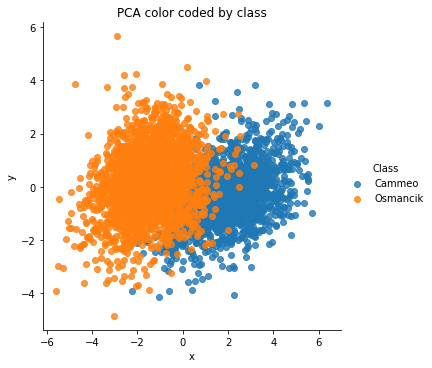

In [9]:
import seaborn as sns
sns.lmplot('x', 'y', data=data_m, hue='Class', fit_reg=False).set(title='PCA color coded by class')

plt.show()

#### 1.5 Comment on what the graph suggests about the effeciveness of using k-nearest neighbors on this 2-dimensional reduction of the data to predict the type of rice. (4 points)

This produced graph suggests that if the knn is run on this data, it has a medium to high chance of corretly classifying the type of rice, given majority of the points in the graph is well separated. Given the boundary of two clusters in the middle is blurry, this is indicative of a poor classification by knn when x falls in range(-2,2) and y falls in range(-2,2).

#### 1.6 Using a reasonable train-test split with your k-nearest neighbors implementation, give the confusion matrix for predicting the type of rice with k=1. (4 points) Repeat for k=5. (4 points)

Recall: All normalization must be based on the training set mean and standard deviation, not on data including the test set. Once the pca reduction has been trained, you can apply it to test data via, e.g.

In [10]:
# first use the original data for train test split
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [11]:
#then use the train data mean and standard deviation to normalize both data
mean_cols = []
std_cols = []
for i in train_data.columns[0:7]:
  mean_col = np.mean(train_data[i])
  std_col = np.std(train_data[i])
  mean_cols.append(mean_col)
  std_cols.append(std_col)
  train_data[i] = (train_data[i]-mean_col)/std_col

In [12]:
for j in range(7):
  mean_col = mean_cols[j]
  std_col = std_cols[j]
  i = test_data.columns[0:7][j]
  test_data[i] = (test_data[i]-mean_col)/std_col

In [13]:
train_data_reduced = pca.transform(train_data[my_cols])
test_data_reduced = pca.transform(test_data[my_cols])

In [14]:
train_set = pd.DataFrame({"x": train_data_reduced[:, 0], "y": train_data_reduced[:, 1], "Class": train_data["Class"]})
train_set = train_set.values.tolist()
test_set = pd.DataFrame({"x": test_data_reduced[:, 0], "y": test_data_reduced[:, 1], "Class": test_data["Class"]})
test_set = test_set.values.tolist()

In [21]:
knn_fit = knn(train_set)

In [22]:
knn_fit.classify(1,2,3)

'Osmancik'

In [23]:
actual = test_data["Class"]

In [24]:
predicted = knn_fit.predict(data=test_set,k=5)

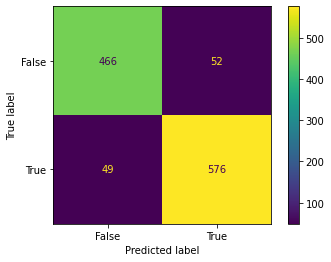

In [25]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

#### 1.7 Provide a brief interpretation of what the confusion matrix results mean. (4 points)